In [1]:
# Import Required Libraries
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "4" 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
from imblearn.over_sampling import SMOTE

# Step 1: Load the Data
# Replace 'large_data.csv' with your dataset file path
data = pd.read_csv('large_data.csv')

# Step 2: Data Overview
print("Dataset Information:")
print(data.info())
print("\nStatistical Summary:")
print(data.describe())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44453 entries, 0 to 44452
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   COUGH                 44453 non-null  int64 
 1   MUSCLE_ACHES          44453 non-null  int64 
 2   TIREDNESS             44453 non-null  int64 
 3   SORE_THROAT           44453 non-null  int64 
 4   RUNNY_NOSE            44453 non-null  int64 
 5   STUFFY_NOSE           44453 non-null  int64 
 6   FEVER                 44453 non-null  int64 
 7   NAUSEA                44453 non-null  int64 
 8   VOMITING              44453 non-null  int64 
 9   DIARRHEA              44453 non-null  int64 
 10  SHORTNESS_OF_BREATH   44453 non-null  int64 
 11  DIFFICULTY_BREATHING  44453 non-null  int64 
 12  LOSS_OF_TASTE         44453 non-null  int64 
 13  LOSS_OF_SMELL         44453 non-null  int64 
 14  ITCHY_NOSE            44453 non-null  int64 
 15  ITCHY_EYES     

In [2]:
# Step 3: Handle Missing Values
numerical_features = data.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = data.select_dtypes(include=['object']).columns.tolist()

# Impute missing values
numerical_imputer = SimpleImputer(strategy='median')
categorical_imputer = SimpleImputer(strategy='most_frequent')

data[numerical_features] = numerical_imputer.fit_transform(data[numerical_features])
data[categorical_features] = categorical_imputer.fit_transform(data[categorical_features])

In [3]:
# Step 4: Normalize Numerical Features
scaler = StandardScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# Step 5: Encode Categorical Features
encoder = OneHotEncoder(sparse_output=False)
encoded_categorical = encoder.fit_transform(data[categorical_features])
encoded_categorical_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(categorical_features))

# Merge encoded data and drop original categorical columns
data = pd.concat([data.reset_index(drop=True), encoded_categorical_df.reset_index(drop=True)], axis=1)

In [4]:
# Step 6: Separate Features and Target
# Assume 'TYPE' is the target column
encoded_columns = encoded_categorical_df.columns.tolist()
X = data.drop(columns=encoded_columns)

# Map target values directly from the categorical columns
class_mapping = {col: i for i, col in enumerate(encoded_columns)}
y = data[encoded_columns].idxmax(axis=1).map(lambda x: class_mapping.get(x))

# Ensure all features are numeric
y = y.astype(int)

In [5]:
# Step 7: Handle Class Imbalance Using SMOTE
# Convert X to a numeric DataFrame if needed
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

# Ensure compatibility for SMOTE
X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X, y)



KNN Accuracy: 95.36%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      4977
           1       0.93      0.99      0.96      5007
           2       0.90      0.98      0.94      4974
           3       1.00      0.88      0.93      5042

    accuracy                           0.95     20000
   macro avg       0.96      0.95      0.95     20000
weighted avg       0.96      0.95      0.95     20000



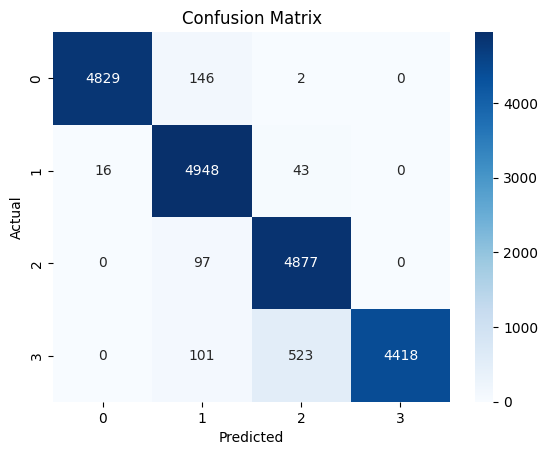

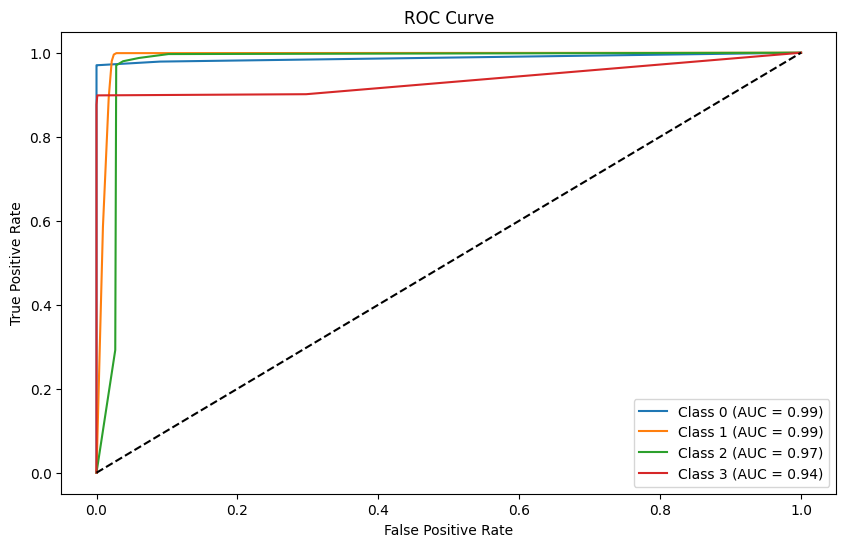

In [6]:
# Step 8: Split the Data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Step 9: Build and Train KNN Model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Step 10: Evaluate the Model
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"KNN Accuracy: {accuracy * 100:.2f}%")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plot ROC Curve
y_test_bin = pd.get_dummies(y_test)
y_pred_prob = knn.predict_proba(X_test)

plt.figure(figsize=(10, 6))
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin.iloc[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

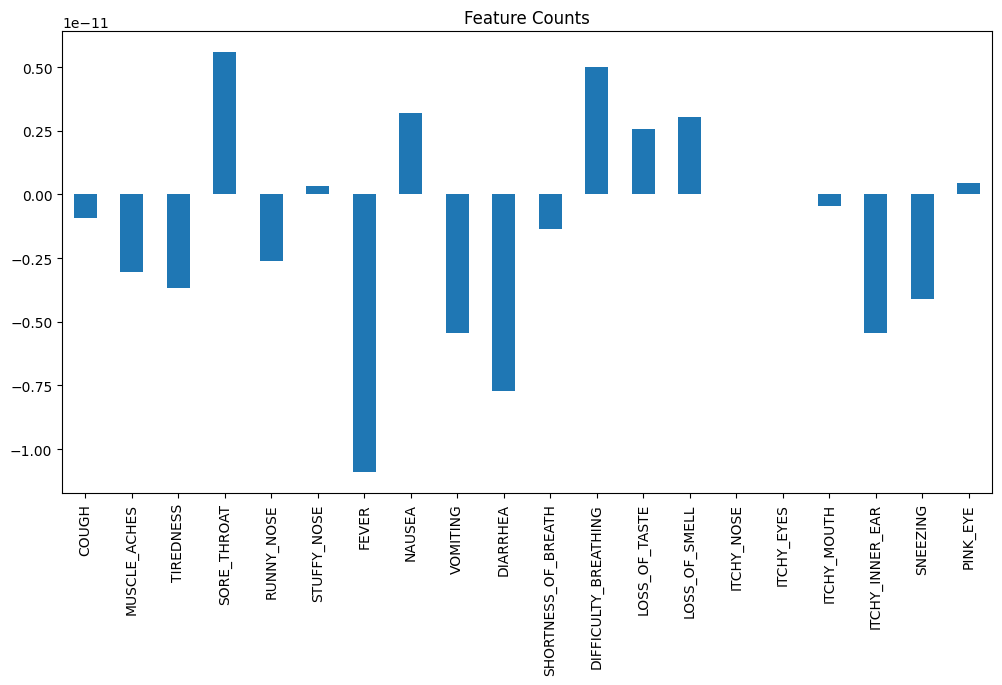

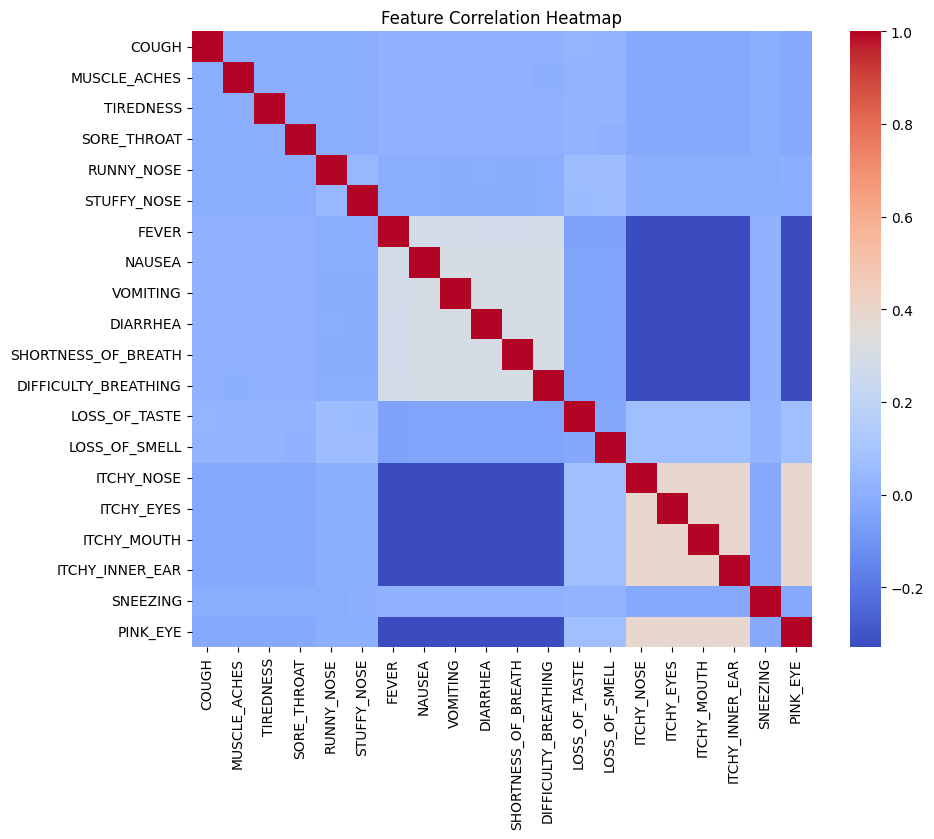

In [7]:
# Step 11: Exploratory Data Analysis (EDA)
# Feature Distribution
plt.figure(figsize=(12, 6))
data[numerical_features].sum().plot(kind='bar')
plt.title('Feature Counts')
plt.xticks(rotation=90)
plt.show()

# Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data[numerical_features].corr(), cmap='coolwarm', annot=False)
plt.title('Feature Correlation Heatmap')
plt.show()